In [1]:
import os
import sys
import numpy as np
import torch
import librosa
import librosa.display
import torch
import torchaudio
import matplotlib.pyplot as plt
import soundfile as sf
import math
import warnings

from audio_utils import sound_preprocess, to_np, to_tensor


In [2]:
def to_np(data):
    if torch.is_tensor(data):
        return data.detach().cpu().numpy()
    return data


def to_tensor(data, dtype=np.float32):
    if isinstance(data, (np.ndarray, np.generic)):
        return torch.from_numpy(data.astype(dtype))
    return data


def mlsp_plot(mlsp, plot_path, sr, hop_length):
    fig, ax = plt.subplots(figsize=(25, 5))
    img = librosa.display.specshow(mlsp, x_axis="time", y_axis="mel", sr=sr, hop_length=hop_length, fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set(title="Mel-frequency spectrogram")
    plt.savefig(plot_path)

def spec_plot(spec, plot_path, sr, hop_length):
    fig, ax = plt.subplots(figsize=(25, 5))
    img = librosa.display.specshow(spec, x_axis="time", y_axis="linear", sr=sr, hop_length=hop_length, fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set(title="Spectrogram")
    plt.savefig(plot_path)

def waveform_plot(wav, plot_path, sr):
    fig, ax = plt.subplots(figsize=(25, 5))
    librosa.display.waveplot(wav, x_axis="time", sr=sr, ax=ax)
    ax.set(title="Waveform")
    plt.savefig(plot_path)

def waveform_normalize(wav):
    wav = to_np(wav)
    max = np.max(np.abs(wav))
    return np.multiply(wav, 1/max)
    

def mlsp_reshape(mlsp):
    # length, freq, frame = mlsp.shape
    mlsp = to_np(mlsp)
    result = np.concatenate([mlsp[i] for i in range(len(mlsp))], axis=1)
    return result

def sound_preprocess(wav_path, plot_path=None, divide_mode="mlsp", library="librosa", device="cpu", start_point=None, end_point=None):
    """
    wav file convert to mel-spectrogram numpy array divide 10Hz

    Args:
        wav_path (str): path to wav file
        plot_path (str, optional): if you want to plot mlsp, enter the path to save image dir. Defaults to None.
        divide_mode (str, optional): select wav or mlsp. Defaults to "wav".
        library (str, optional): select librosa or torchaudio. Defaults to "librosa".

    Returns:
        numpy array: 10Hz mlsp (normalized 0~1)
    """

    # fft parameter
    sr = 16000
    fft_size = 1024
    frame_period = 5  # ms
    target_hz = 10
    n_mels = 128
    hop_length = int(0.001 * sr * frame_period)
    frame_num = int((1 / target_hz) / (0.001 * frame_period))
    top_db = 80.0
    multiplier = 10.0
    amin = 1e-10
    ref_value = np.max
    # db_multiplier = math.log10(max(amin, ref_value))
    
    if library=="librosa" and device in "cuda":
        warnings.warn("Warning : librosa work on CPU only. if you want to use GPU, you must select library torchaudio")

    device = torch.device(device)
    if library=="torchaudio":
        trans_mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=fft_size,
            win_length=None,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="slaney",
        ).to(device=device)

    # create mel-spectrogram
    wav, sr = librosa.load(wav_path, sr=sr, offset=start_point, duration=end_point-start_point)
    
    sound_array = []
    if divide_mode == "wav":
        wav_frame_num = np.int64(sr * (1 / target_hz))
        if library == "librosa":
            for i in range(len(wav) // wav_frame_num):
                temp = wav[wav_frame_num * i : wav_frame_num * (i + 1)]
                mlsp = librosa.feature.melspectrogram(y=temp, sr=sr, n_fft=fft_size, hop_length=hop_length, htk=False)
                mlsp = librosa.power_to_db(mlsp, ref=ref_value)
                sound_array.append(mlsp[:, :frame_num])
            # sound preprocess [-0 ~ -80] -> [0 ~ 1]
            sound_array = np.array(sound_array).astype(np.float32)
            sound_array = np.divide(np.abs(sound_array), 80).astype(np.float32)
        elif library == "torchaudio":
            for i in range(len(wav) // wav_frame_num):
                temp = torch.FloatTensor(wav[wav_frame_num * i : wav_frame_num * (i + 1)]).to(device=device)
                mlsp_power = trans_mel(temp)
                ref_value = mlsp_power.max(dim=1)[0].max(dim=0)[0]
                mlsp = torchaudio.functional.amplitude_to_DB(trans_mel(temp), multiplier, amin, math.log10(max(amin, ref_value)), top_db)
                # sound preprocess [-0 ~ -80] -> [0 ~ 1]
                mlsp = torch.narrow(mlsp.abs().float().div_(80), 1, 0, frame_num).cpu().detach().numpy().copy()
                sound_array.append(mlsp)
            del trans_mel, temp, mlsp_power, ref_value
    elif divide_mode == "mlsp":
        if library == "librosa":
            mlsp = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=fft_size, hop_length=hop_length, htk=False)
            mlsp = librosa.power_to_db(mlsp, ref=ref_value)
            # slice mlsp to target Hz
            freq, total_frame = mlsp.shape
            for i in range(int(total_frame // frame_num)):
                temp = mlsp.T[frame_num * i : frame_num * (i + 1)]
                sound_array.append(temp.T)
            # sound preprocess [-0 ~ -80] -> [0 ~ 1]
            sound_array = np.array(sound_array).astype(np.float32)
            sound_array = np.divide(np.abs(sound_array), 80).astype(np.float32)
        elif library == "torchaudio":
            temp = torch.FloatTensor(wav).to(device=device)
            # mlsp = power2db(trans_mel(temp))
            mlsp_power = trans_mel(temp)
            ref_value = mlsp_power.max(dim=1)[0].max(dim=0)[0]
            mlsp = torchaudio.functional.amplitude_to_DB(trans_mel(temp), multiplier, amin, math.log10(max(amin, ref_value)), top_db)
            # sound preprocess [-0 ~ -80] -> [0 ~ 1]
            mlsp = mlsp.abs().float().div_(80).cpu().detach().numpy().copy()
            # slice mlsp to target Hz
            freq, total_frame = mlsp.shape
            for i in range(int(total_frame // frame_num)):
                temp = mlsp.T[frame_num * i : frame_num * (i + 1)]
                sound_array.append(temp.T)
            del trans_mel, temp, ref_value, mlsp
        else:
            print("Error : please select library torchaudio or librosa", file=sys.stderr)
            raise NotImplementedError()
    return sound_array

def sound_postprocess(mlsp, library="librosa", device="cpu"):
    # fft parameter
    sr = 16000
    fft_size = 1024
    frame_period = 5  # ms
    target_hz = 10
    n_mels = 128
    hop_length = int(0.001 * sr * frame_period)
    frame_num = int((1 / target_hz) / (0.001 * frame_period))
    top_db = 80.0
    multiplier = 10.0
    amin = 1e-10
    ref_value = np.max
    
    if library=="librosa" and device in "cuda":
        warnings.warn("Warning : librosa work on CPU only. if you want to use GPU, you must select library torchaudio")
    device = torch.device(device)

    mlsp = np.multiply(to_np(mlsp), -80)
    if library == "librosa":
        mlsp = librosa.db_to_power(mlsp)
        wav = librosa.feature.inverse.mel_to_audio(mlsp, sr=sr, n_fft=fft_size, hop_length=hop_length)
    elif library == "torchaudio":
        inverseMel = torchaudio.transforms.InverseMelScale(
            n_stft=fft_size // 2 + 1,
            n_mels=n_mels,
            sample_rate=sr,
            f_min=0.0,
            f_max=None,
            max_iter=100000,
            tolerance_loss=1e-05,
            tolerance_change=1e-08,
            sgdargs=None,
            norm=None,
            mel_scale="slaney",
        ).to(device=device)
        inverseWav = torchaudio.transforms.GriffinLim(
            n_fft=fft_size,
            n_iter=32,
            win_length=None,
            hop_length=hop_length,
            power=2.0,
            momentum=0.99,
            length=None,
            rand_init=True,
        ).to(device=device)
        
        mlsp = to_tensor(mlsp).to(device=device)
        mlsp = torchaudio.functional.DB_to_amplitude(mlsp, ref=1.0, power=0.5)
        wav = inverseWav(inverseMel(mlsp))
        wav = to_np(wav)
        del inverseMel, inverseWav, mlsp
    else:
        print("Error : please select library torchaudio or librosa", file=sys.stderr)
        raise NotImplementedError()
    return wav


tensor(0.)


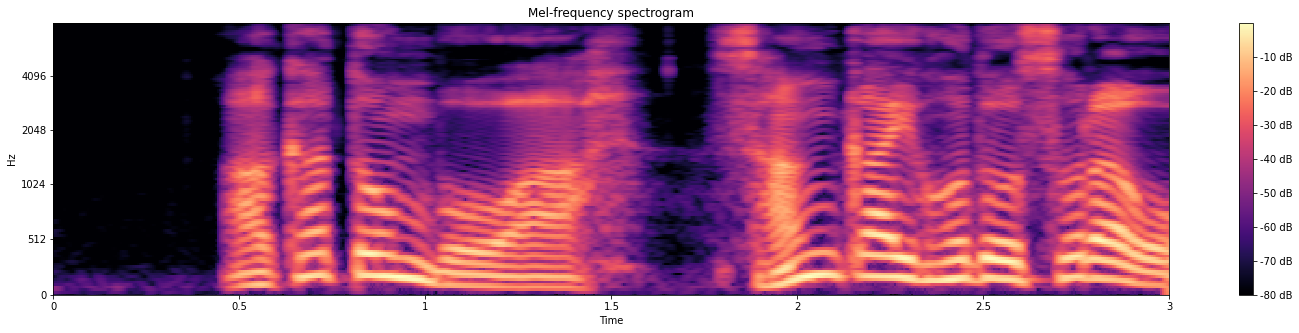

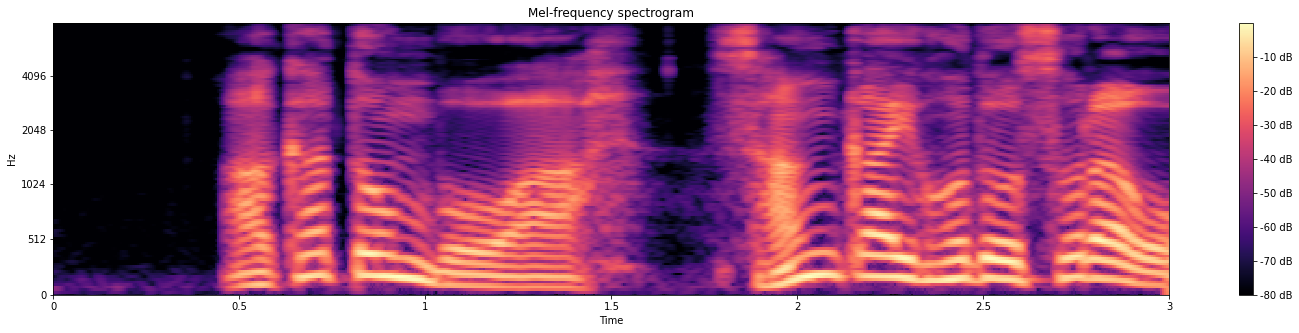

In [3]:
# fft parameter
sr = 16000
fft_size = 1024
frame_period = 5  # ms
target_hz = 10
n_mels = 128
hop_length = int(0.001 * sr * frame_period)
frame_num = int((1 / target_hz) / (0.001 * frame_period))
top_db = 80.0
multiplier = 10.0
amin = 1e-10
ref_value = np.max

wav_path = 'wav/akatonbo.wav'

mlsp_array_librosa = np.array(sound_preprocess(wav_path=wav_path, plot_path=None, divide_mode='mlsp', library="librosa", start_point=0, end_point=3))
mlsp_librosa = mlsp_reshape(mlsp_array_librosa)

mlsp_array_torch = np.array(sound_preprocess(wav_path=wav_path, plot_path=None, divide_mode='mlsp', library="torchaudio", device="cuda:0", start_point=0, end_point=3))
mlsp_torch = mlsp_reshape(mlsp_array_librosa)

mlsp_plot(np.multiply(to_np(mlsp_librosa), -80), os.path.join('wav', 'mlsp_librosa.pdf'), sr, hop_length)
mlsp_plot(np.multiply(to_np(mlsp_torch), -80), os.path.join('wav', 'mlsp_torch.pdf'), sr, hop_length)

print(torch.nn.functional.mse_loss(to_tensor(mlsp_librosa), to_tensor(mlsp_torch)))

# wav_librosa = sound_postprocess(mlsp_librosa, library='librosa')

# wavpath_librosa = "{}/wav_librosa.wav".format("wav")
# sf.write(wavpath_librosa, wav_librosa, sr)

tensor(3.6367e-18)
tensor(0.0277)
tensor(8.8272e-05)


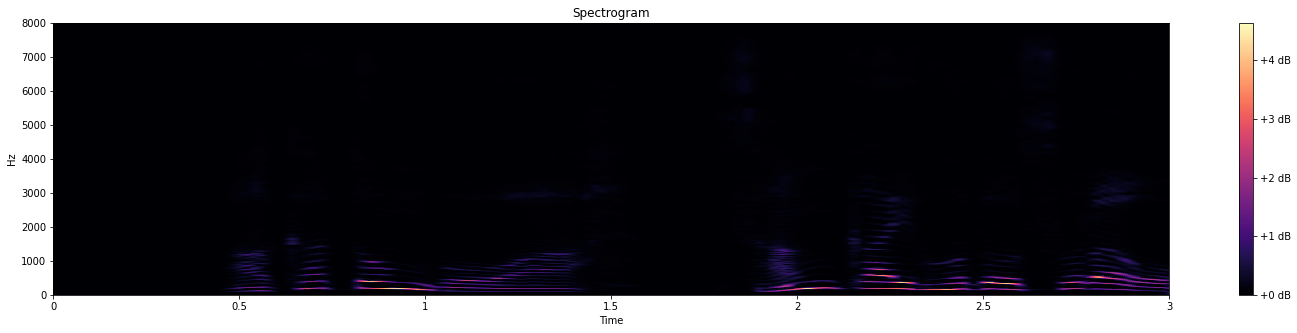

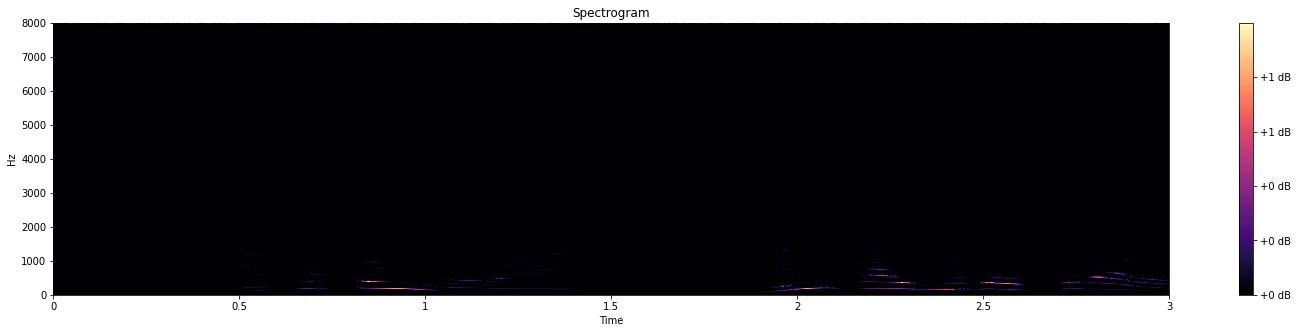

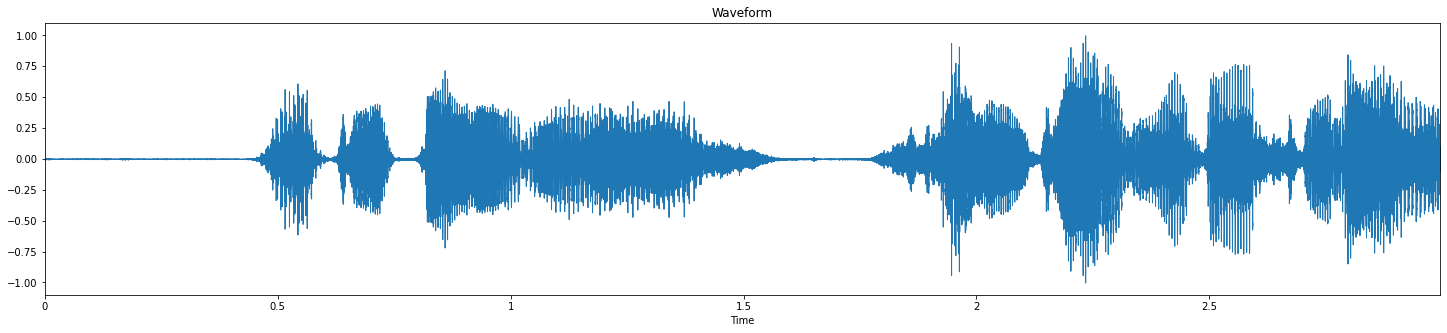

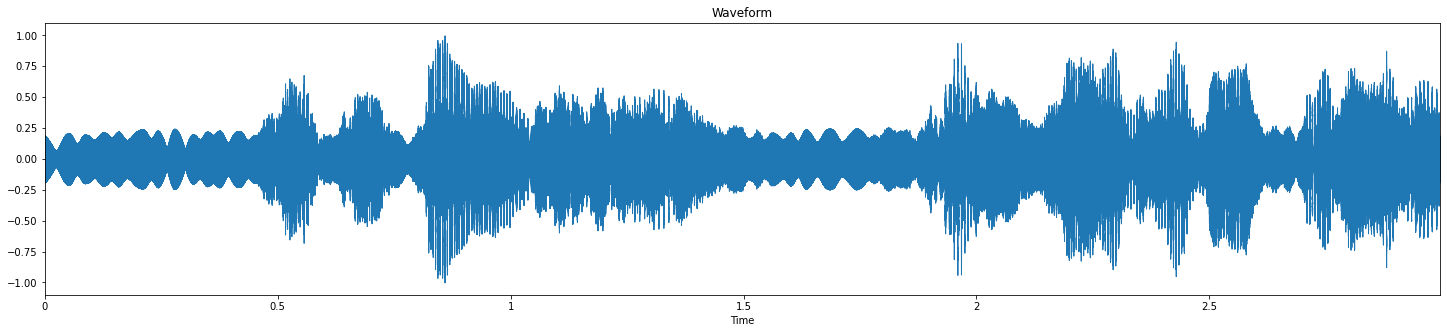

In [11]:
def sound_postprocess_tester(mlsp, library="librosa", device="cpu"):
    # fft parameter
    sr = 16000
    fft_size = 1024
    frame_period = 5  # ms
    target_hz = 10
    n_mels = 128
    hop_length = int(0.001 * sr * frame_period)
    frame_num = int((1 / target_hz) / (0.001 * frame_period))
    top_db = 80.0
    multiplier = 10.0
    amin = 1e-10
    ref_value = np.max
    
    if library=="librosa" and "cuda" in device:
        warnings.warn("Warning : librosa work on CPU only. if you want to use GPU, you must select library torchaudio")
    device = torch.device(device)

    mlsp = np.multiply(to_np(mlsp), -80)
    if library == "librosa":
        
        sr=sr
        n_fft=fft_size
        hop_length=hop_length
        win_length=None
        window="hann"
        center=True
        pad_mode="constant"
        power=2.0
        n_iter=32
        length=None
        dtype=np.float32
        
        mlsp = librosa.db_to_power(mlsp)
        spec = librosa.feature.inverse.mel_to_stft(mlsp, sr=sr, n_fft=n_fft, power=power)
        wav = librosa.griffinlim(spec, n_iter=n_iter, hop_length=hop_length, win_length=win_length, window=window, center=center, dtype=dtype, length=length, pad_mode=pad_mode,)
        
    elif library == "torchaudio":
        inverseMel = torchaudio.transforms.InverseMelScale(
            n_stft=int(fft_size // 2 + 1),
            n_mels=n_mels,
            sample_rate=sr,
            f_min=0.0,
            f_max=sr / 2.0,
            max_iter=100000000,
            tolerance_loss=1e-50,
            tolerance_change=1e-08,
            sgdargs=None,
            norm=None,
            mel_scale="slaney",
        ).to(device=device)
        inverseWav = torchaudio.transforms.GriffinLim(
            n_fft=fft_size,
            n_iter=32,
            win_length=fft_size,
            hop_length=hop_length,
            power=2.0,
            momentum=0.99,
            length=None,
            rand_init=True,
        ).to(device=device)
        
        mlsp = to_tensor(mlsp).to(device=device)
        mlsp = torchaudio.functional.DB_to_amplitude(mlsp, ref=1.0, power=1.0)
        # mlsp = to_tensor(librosa.db_to_power(mlsp)).to(device=device)
        # mlsp = librosa.db_to_power(mlsp)
        # spec = to_tensor(librosa.feature.inverse.mel_to_stft(mlsp, sr=sr, n_fft=fft_size, power=2.0)).to(device=device)
        spec = inverseMel(mlsp)
        wav = inverseWav(spec)
        mlsp = to_np(mlsp)
        spec = to_np(spec)
        wav = to_np(wav)
        del inverseMel, inverseWav
    else:
        print("Error : please select library torchaudio or librosa", file=sys.stderr)
        raise NotImplementedError()
    return wav, spec, mlsp

wav_librosa, spec_librosa, mlsp_pw_librosa = sound_postprocess_tester(mlsp_librosa, library='librosa')
wav_torch, spec_torch, mlsp_pw_torch = sound_postprocess_tester(mlsp_torch, library="torchaudio", device="cuda:0")

print(torch.nn.functional.mse_loss(to_tensor(mlsp_pw_librosa), to_tensor(mlsp_pw_torch)))
print(torch.nn.functional.mse_loss(to_tensor(spec_librosa), to_tensor(spec_torch)))
print(torch.nn.functional.mse_loss(to_tensor(wav_librosa), to_tensor(wav_torch)))

spec_plot(spec_librosa, os.path.join('wav', 'spec_librosa.pdf'), sr=sr, hop_length=hop_length)
spec_plot(spec_torch, os.path.join('wav', 'spec_torch.pdf'), sr=sr, hop_length=hop_length)

waveform_plot(waveform_normalize(wav_librosa), os.path.join('wav', 'wav_librosa.pdf'), sr=sr)
waveform_plot(waveform_normalize(wav_torch), os.path.join('wav', 'wav_torch.pdf'), sr=sr)